In [197]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
# --- Load Data ---
sept2013c3 = pd.read_csv('sept2013c3.csv')
X = sept2013c3.drop(columns=['Class'])
y = sept2013c3['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [188]:
# Function for evaluating models
def optimal_threshold (y_pred):
    precision, recall, optthreshold = precision_recall_curve(y_test, y_pred)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    opt_threshold = optthreshold[optimal_idx]
    print(f"Optimal Threshold: {opt_threshold:.2f}")
    
def evalThresholds (y_pred_proba, thresholds):
    for threshold in thresholds:
            y_pred_adjusted = (y_pred_proba > threshold).astype(int)
            print(f"\n-------- Threshold: {threshold} --------")
            print("Confusion Matrix:")
            print(confusion_matrix(y_test, y_pred_adjusted))
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_adjusted, target_names=['Class 0', 'Class 1']))
            print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


def evaluate_model(model, X_test, y_test, thresholds=[.5]):
    if isinstance(model, LogisticRegression):
        y_pred = model.predict_proba(X_test)[:, 1]
        optimal_threshold(y_pred)
        
    if hasattr(model, 'predict_proba'):
        y_pred = model.predict_proba(X_test)[:, 1]
    else:
        y_pred = model.predict(X_test)
        optimal_threshold(y_pred)

    evalThresholds(y_pred, thresholds)

In [60]:
# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=150, 
    random_state=42,
    )
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [189]:
# Evaluate RF Classifier
evaluate_model(rf_model, X_test, y_test)


-------- Threshold: 0.5 --------
Confusion Matrix:
[[56862     2]
 [   23    75]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9624


In [ ]:
# Convert DataFrame, Build, and Train
X_train_cnn = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

# Building the CNN model
cnn_model = Sequential([
    Conv1D(128, 15, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
    )

# Callbacks & Train (CNN)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
    )

class_weights = {0: 1, 1: 3}
y_train = y_train.flatten()
history = cnn_model.fit(
    X_train_cnn,
    y_train,
    class_weight= class_weights,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7121/7121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9845 - loss: 0.0758 - val_accuracy: 0.9993 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 2/20
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9993 - loss: 0.0114 - val_accuracy: 0.9993 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 3/20
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9993 - loss: 0.0100 - val_accuracy: 0.9993 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 4/20
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9993 - loss: 0.0111 - val_accuracy: 0.9993 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 5/20
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9994 - loss: 0.0079 - val_accuracy: 0.9994 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 6/20
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9993 - loss: 0.0088 - val_accuracy: 0.9994 - val_loss: 0.0032 - learning_rate: 1.0000e-04
Epoch 7/20
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - 

In [190]:
# Evaluate CNN model
evaluate_model(cnn_model, X_test_cnn, y_test, thresholds = [ .5, .77])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Optimal Threshold: 0.77

-------- Threshold: 0.5 --------
Confusion Matrix:
[[56848    16]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9863

-------- Threshold: 0.77 --------
Confusion Matrix:
[[56853    11]
 [   18    80]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.88      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9863


In [ ]:
# Get the predictions from both models
rf_train_pred = rf_model.predict_proba(X_train)[:, 1]
rf_test_pred = rf_model.predict_proba(X_test)[:, 1]

cnn_train_pred = cnn_model.predict(X_train_cnn).flatten()
cnn_test_pred = cnn_model.predict(X_test_cnn).flatten()

# Stack the predictions of both models (use as features for the meta-model)
X_train_stack = np.column_stack((rf_train_pred, cnn_train_pred))
X_test_stack = np.column_stack((rf_test_pred, cnn_test_pred))


7121/7121 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [183]:
# Train the meta-model (Logistic Regression)
meta_model = LogisticRegression()
meta_model.fit(X_train_stack, y_train)

# Make final predictions using the meta-model
y_pred_proba_meta = meta_model.predict_proba(X_test_stack)[:, 1]



In [193]:
# Performance Metrics
evaluate_model(meta_model, X_test_stack, y_test, [ .33, .48, .5, .77, .99])

Optimal Threshold: 0.48

-------- Threshold: 0.33 --------
Confusion Matrix:
[[56858     6]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.93      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9873

-------- Threshold: 0.48 --------
Confusion Matrix:
[[56859     5]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.94      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9873

-------- Threshold: 0.5 --------
Confusion Matrix:
[[56859   

Cross-Validation Scores: [0.99991222 0.99997806 0.99997806 1.         0.99997806]
Mean Cross-Validation Score: 0.9999692773596085


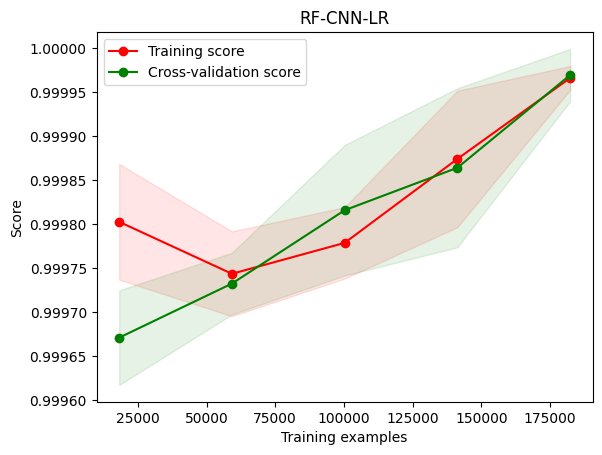

In [ ]:
# Cross-validation
scores = cross_val_score(meta_model, X_train_stack, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    meta_model, X_train_stack, y_train, cv=5, n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("RF-CNN-LR")
plt.show()